In [72]:
import foolbox as fb
from foolbox.attacks import LinfPGD
from PIL import Image
import numpy as np
import torch

import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD
import torchvision.transforms as transforms

In [15]:
model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
(images, labels), restore_type = ep.astensors_(*samples(fmodel, dataset="imagenet", batchsize=16))
clean_acc = accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  93.8 %


In [64]:
torch.max(restore_type(fmodel(images)), dim=1)

torch.return_types.max(
values=tensor([18.0525, 17.3928, 17.7660, 13.5952, 15.5371, 16.4859,  8.8682, 13.1451,
        28.3597, 17.7090, 19.1734, 17.7749, 17.5877, 14.0145,  9.8759, 19.7554],
       device='cuda:0'),
indices=tensor([243, 559, 438, 990, 949, 853, 609, 511, 915, 455, 541, 630, 741, 471,
        129,  99], device='cuda:0'))

In [65]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [5]:
attack = LinfPGD()
epsilons = [8/255.]

In [6]:
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [7]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.03137254901960784:  0.0 %


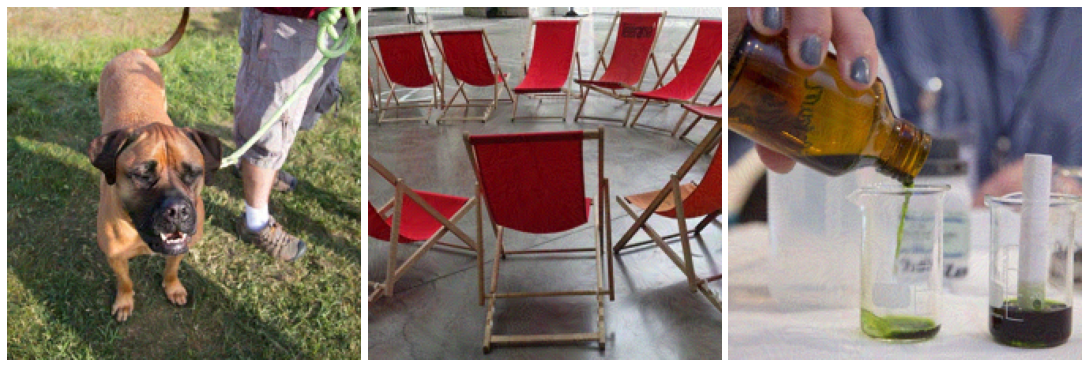

In [9]:
fb.plot.images(clipped_advs[0], n=3, scale=5)

In [21]:
clipped_advs[0].shape

torch.Size([16, 3, 224, 224])

In [25]:
restore_type(clipped_advs[0]).cpu().numpy().shape

(16, 3, 224, 224)

In [35]:
image_array = restore_type(clipped_advs[0]).cpu().numpy()

In [39]:
image_array.shape

(16, 3, 224, 224)

In [49]:
np_img = (image_array / np.max(image_array) * 255).astype(np.uint8)

In [50]:
np_img.shape

(16, 3, 224, 224)

In [54]:
np_img[0].shape

(3, 224, 224)

In [67]:
image = Image.fromarray(np_img[0].transpose((1,2,0)))

In [68]:
path = "/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/images"

In [69]:
image.save(f'{path}/{0}.png', 'PNG')

In [70]:
image = Image.open(f'{path}/{0}.png') 

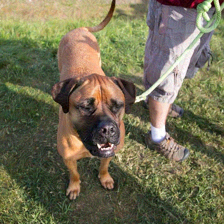

In [71]:
image

In [73]:
transform = transforms.ToTensor()

In [77]:
tensor = transform(image).unsqueeze(0)

In [78]:
tensor.shape

torch.Size([1, 3, 224, 224])

In [79]:
tensor.shape

torch.Size([1, 3, 224, 224])

In [82]:
out = fmodel(tensor.to('cuda'))

In [87]:
out.shape

torch.Size([1, 1000])

In [93]:
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([60.1318], device='cuda:0'),
indices=tensor([242], device='cuda:0'))

In [95]:
image = Image.open("/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/nor/ILSVRC2012_val_00007004.JPEG")

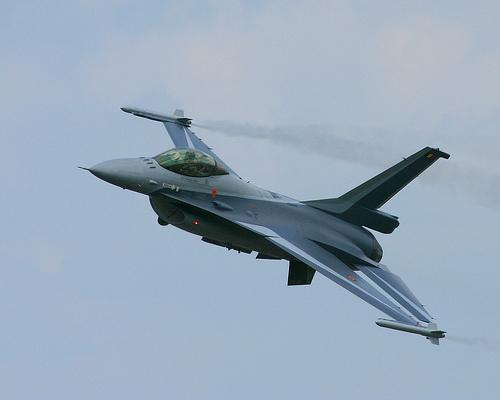

In [99]:
image

In [98]:
image.size

(500, 400)

In [121]:
transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [122]:
transformed_image = transform(image)

In [123]:
transformed_image.shape

torch.Size([3, 256, 256])

In [124]:
to_pil = ToPILImage()
pil_image = to_pil(transformed_image)

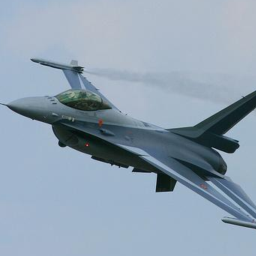

In [125]:
pil_image.show()

In [126]:
transform = transforms.ToTensor()

In [129]:
tensor = transform(pil_image).unsqueeze(0)

In [130]:
tensor.shape

torch.Size([1, 3, 256, 256])

In [131]:
out = fmodel(tensor.to('cuda'))

In [132]:
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([16.4596], device='cuda:0'),
indices=tensor([895], device='cuda:0'))

In [133]:
path = "/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/nor"

In [135]:
pil_image.save(f'{path}/{0}.png', 'PNG')

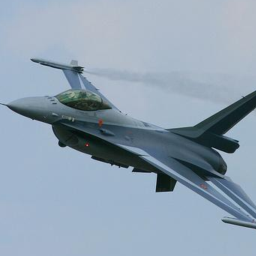

In [158]:
raw_advs, clipped_advs, success = attack(fmodel, transformed_image.unsqueeze(0).cuda(), torch.tensor([895]).cuda(), epsilons=epsilons)

In [159]:
out = fmodel(clipped_advs[0])
torch.max(out, dim=1)

In [161]:
pil_image_adv = to_pil(clipped_advs[0][0])

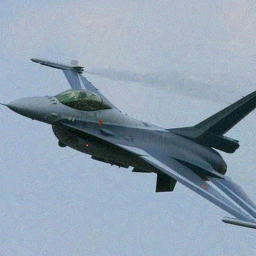

In [162]:
pil_image_adv

In [164]:
path = "/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/images/att"

In [165]:
pil_image_adv.save(f'{path}/{0}.png', 'PNG')

In [166]:
adv = Image.open(f'{path}/{0}.png')

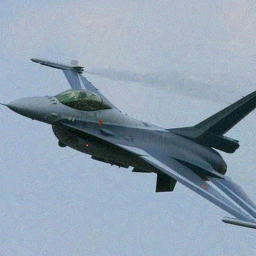

In [168]:
adv

In [182]:
adv_np = np.array(adv).transpose((2,0,1))
adv_np / 255

array([[[0.62352941, 0.59607843, 0.59607843, ..., 0.70196078,
         0.67843137, 0.73333333],
        [0.61960784, 0.59607843, 0.61960784, ..., 0.69019608,
         0.69803922, 0.68235294],
        [0.63921569, 0.65490196, 0.63137255, ..., 0.70588235,
         0.73333333, 0.68627451],
        ...,
        [0.64313725, 0.68235294, 0.68235294, ..., 0.60392157,
         0.62745098, 0.63921569],
        [0.61568627, 0.64705882, 0.67843137, ..., 0.61568627,
         0.64313725, 0.6627451 ],
        [0.63529412, 0.61568627, 0.63529412, ..., 0.60784314,
         0.6       , 0.65098039]],

       [[0.70196078, 0.68235294, 0.67843137, ..., 0.75686275,
         0.74509804, 0.7254902 ],
        [0.6745098 , 0.68235294, 0.69803922, ..., 0.76470588,
         0.76862745, 0.72156863],
        [0.69803922, 0.69411765, 0.69803922, ..., 0.74509804,
         0.72156863, 0.70980392],
        ...,
        [0.69019608, 0.71764706, 0.67843137, ..., 0.69411765,
         0.72156863, 0.70588235],
        [0.7

In [195]:
tmp = torch.from_numpy(np.array(adv).transpose((2,0,1))/255).unsqueeze(dim=0).float()

In [194]:
tmp.float().dtype

torch.float32

In [196]:
out = fmodel(tmp.cuda())

In [197]:
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([45.5087], device='cuda:0'),
indices=tensor([908], device='cuda:0'))

In [198]:
path = "/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/recons/att/0-checkpoint.png"

In [201]:
adv = Image.open(path)
adv_np = np.array(adv).transpose((2,0,1))
adv_np / 255

array([[[0.58039216, 0.54117647, 0.58039216, ..., 0.64313725,
         0.61176471, 0.66666667],
        [0.56862745, 0.59215686, 0.5372549 , ..., 0.66666667,
         0.61568627, 0.6627451 ],
        [0.6       , 0.54117647, 0.61176471, ..., 0.67843137,
         0.65882353, 0.6745098 ],
        ...,
        [0.63529412, 0.60784314, 0.61176471, ..., 0.56078431,
         0.52941176, 0.58039216],
        [0.61568627, 0.63921569, 0.61176471, ..., 0.54509804,
         0.55686275, 0.56470588],
        [0.62352941, 0.63921569, 0.63529412, ..., 0.56078431,
         0.56470588, 0.57647059]],

       [[0.59607843, 0.65882353, 0.61568627, ..., 0.65098039,
         0.67843137, 0.64705882],
        [0.61960784, 0.65490196, 0.64705882, ..., 0.69411765,
         0.64705882, 0.67058824],
        [0.63921569, 0.63529412, 0.62352941, ..., 0.63137255,
         0.65882353, 0.62745098],
        ...,
        [0.66666667, 0.63921569, 0.63529412, ..., 0.61176471,
         0.65098039, 0.62352941],
        [0.6

In [202]:
tmp = torch.from_numpy(np.array(adv).transpose((2,0,1))/255).unsqueeze(dim=0).float()

In [203]:
out = fmodel(tmp.cuda())
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([7.5645], device='cuda:0'),
indices=tensor([94], device='cuda:0'))

In [205]:
path = "/home/lorenzp/DeepFakeDetectors/DIRE/data/adversarial/recons/nor/nor-checkpoint.png"
adv = Image.open(path)
adv_np = np.array(adv).transpose((2,0,1))
tmp = torch.from_numpy(np.array(adv).transpose((2,0,1))/255).unsqueeze(dim=0).float()
out = fmodel(tmp.cuda())
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([5.8641], device='cuda:0'),
indices=tensor([142], device='cuda:0'))